In [253]:
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import numpy as np

# read audio samples
input_data = read("Data PCG\\Mumur\\49627_MV.wav")
audio = input_data[1]
# plot the first 1024 samples
# audio = audio/ np.max(audio)
audio = audio[20000:32000] / np.max(audio)

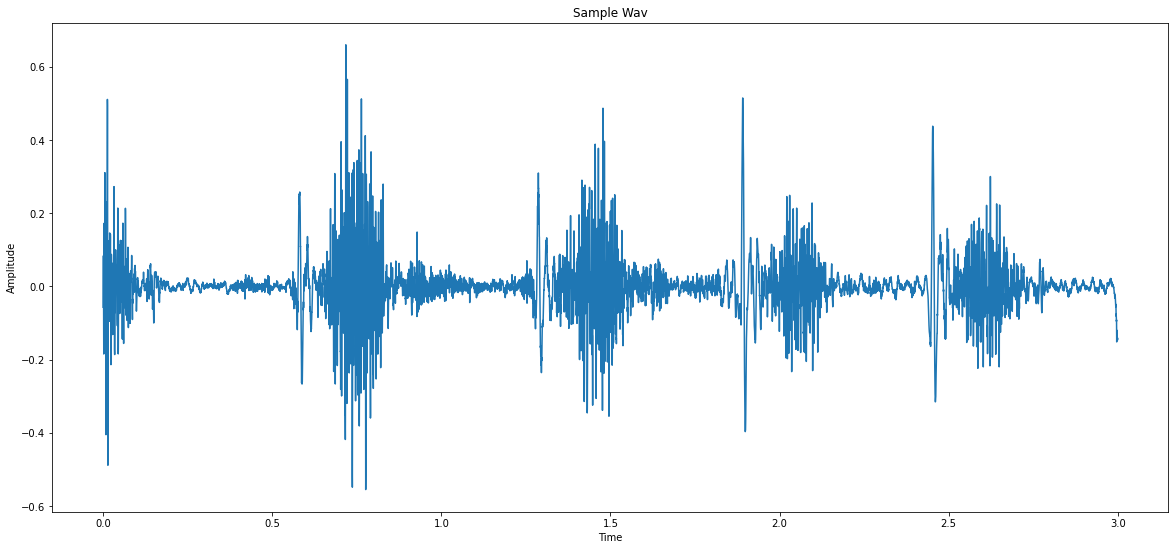

In [254]:
import numpy as np

fs = 4000
a = np.arange(len(audio))
plt.figure(figsize=((20, 9)))
plt.plot(a / fs, audio)
# label the axes
plt.ylabel("Amplitude")
plt.xlabel("Time")
# set the title
plt.title("Sample Wav")
# display the plot
plt.show()

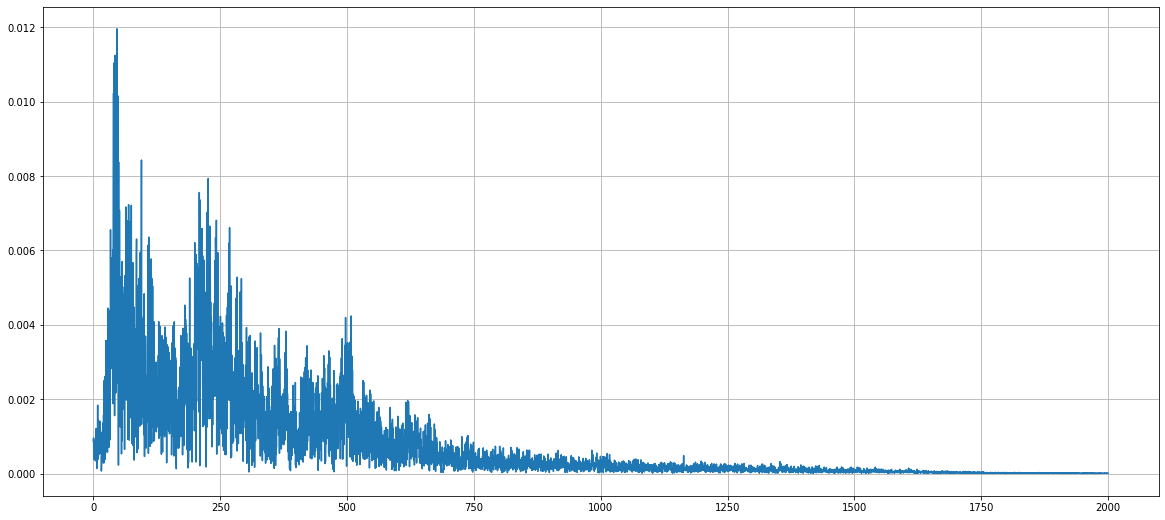

In [255]:
from scipy.fft import fft, fftfreq

N = len(audio)
n = np.arange(0, N, 1, dtype=int)
k = np.arange(0, N, 1, dtype=int)
yf = fft(audio)
plt.figure(figsize=((20, 9)))
plt.plot(k[0 : N // 2] * fs / N, 2.0 / N * np.abs(yf[0 : N // 2]))
plt.grid()
plt.show()

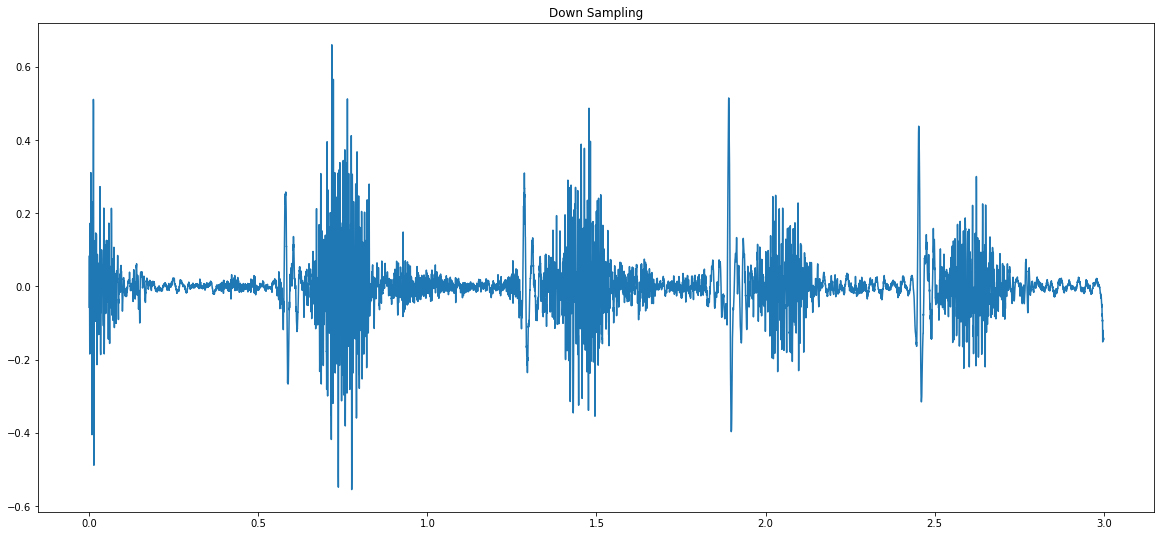

In [256]:
# decimate / down sampling
# N nya global
fcd = np.pi / N
Ndw = 2


def lpffir(omc, i):
    if i == 0:
        y = omc / np.pi
        return y
    else:
        y = np.sin(omc * i) / (i * np.pi)
        return y


omc = (2 * np.pi * fcd) * fs

yn = np.zeros(round(N / Ndw))
# audio Global

for n in range(round(N / Ndw)):
    for m in range(Ndw):
        yn[n] += lpffir(omc, m) * audio[n * Ndw - m]

# a menjadi global
a1 = np.arange(len(yn))
plt.figure(figsize=((20, 9)))
plt.title("Down Sampling")
plt.plot(a / 4000, audio)
# plt.plot(a1/2000,yn)

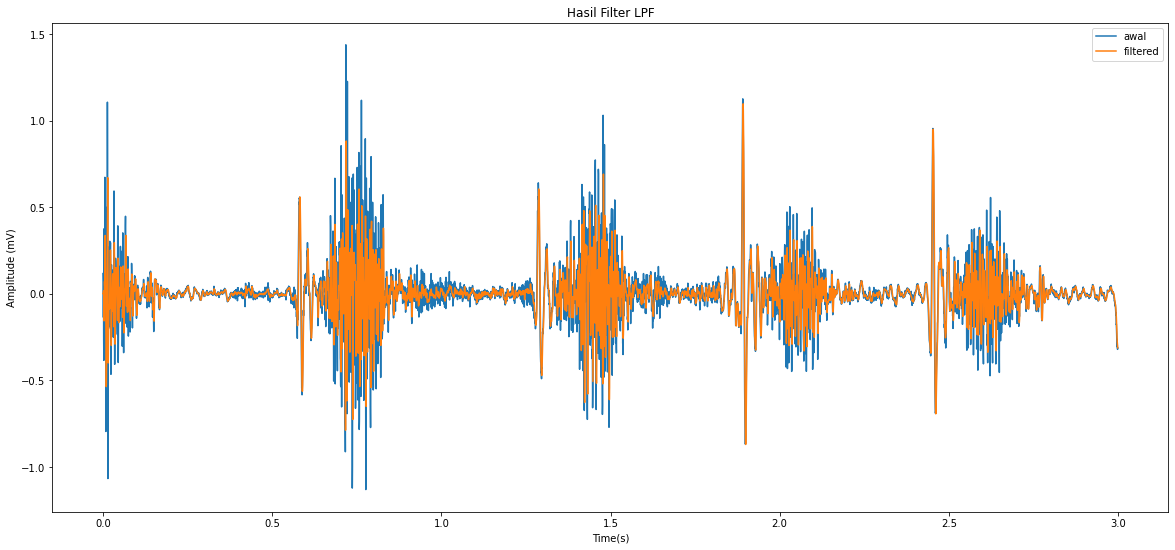

In [257]:
fs = fs / 2
cutoff_frequency = 250
sampling_period = 1 / fs
orde = 2

y = np.zeros(len(yn))  # Initialize the output signal
omega_c = 2 * np.pi * cutoff_frequency
omega_c_squared = omega_c * omega_c
sampling_period_squared = sampling_period * sampling_period

for n in range(2, len(yn)):
    y[n] = (
        ((8 / sampling_period_squared) - 2 * omega_c_squared) * y[n - 1]
        - (
            (4 / sampling_period_squared)
            - (2 * np.sqrt(2) * omega_c / sampling_period)
            + omega_c_squared
        )
        * y[n - 2]
        + omega_c_squared * yn[n]
        + 2 * omega_c_squared * yn[n - 1]
        + omega_c_squared * yn[n - 2]
    ) / (
        (4 / sampling_period_squared)
        + (2 * np.sqrt(2) * omega_c / sampling_period)
        + omega_c_squared
    )

filtered_lowpassMAV = y
plt.figure(figsize=((20, 9)))
plt.plot(a1 / fs, yn, label="awal")
plt.plot(a1 / fs, filtered_lowpassMAV, label="filtered")
plt.legend()
plt.xlabel("Time(s)")
plt.ylabel("Amplitude (mV)")
plt.title("Hasil Filter LPF")
plt.show()

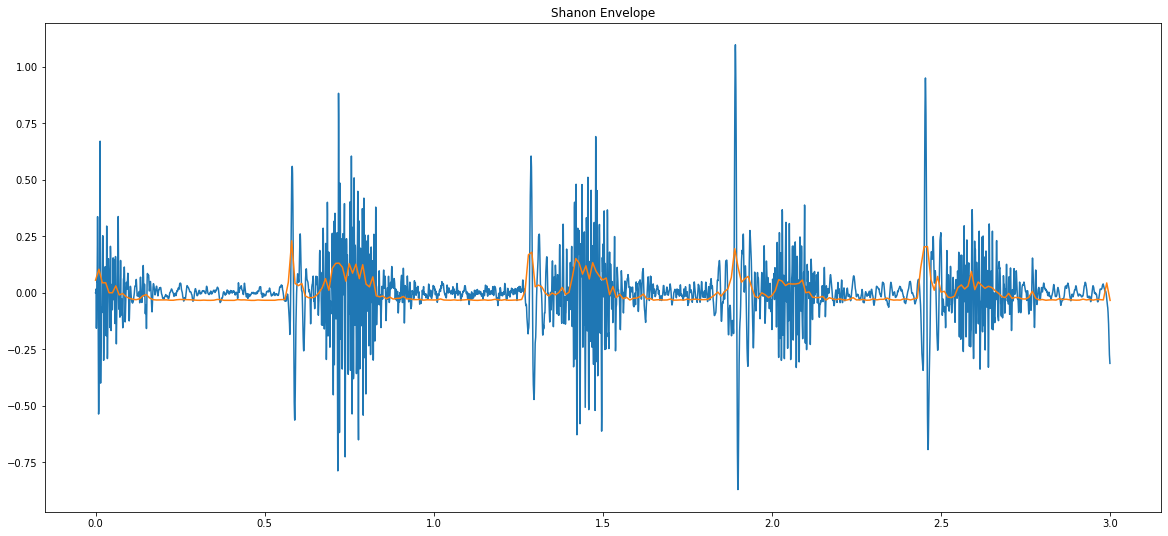

In [258]:
# Shanon Envelope
filtered_highpassMAV = filtered_lowpassMAV
fs = 2000
Ns = 20
xab = np.abs(filtered_highpassMAV)
xma = np.max(xab)
xnor = np.zeros(len(filtered_highpassMAV) + Ns)
for i in range(len(filtered_highpassMAV)):
    xnor[i] = xab[i] / xma


# shanon Energy
et = np.zeros(len(filtered_highpassMAV))

lgth = int(len(xnor) / Ns)
es = np.zeros(lgth)

for s in range(lgth):
    for i in range(s * (round(Ns)), (s * (round(Ns))) + Ns):
        if xnor[i] > 0:
            es[s] += np.square(xnor[i]) * np.log10(np.square(xnor[i]))
        else:
            es[s] = 0
    es[s] = es[s] * (1 / -Ns)

Pts = np.zeros(len(es))
mean_es = np.mean(es)
std_es = np.std(es)

for t in range(lgth):
    Pts[t] = ((es[t] - mean_es) / (std_es)) * 0.05


x = np.arange(len(Pts))
plt.figure(figsize=((20, 9)))
plt.title("Shanon Envelope")
plt.plot(a1 / fs, filtered_lowpassMAV)
plt.plot(x / (fs / Ns), Pts)

In [259]:
# Hilbert Envelope
Ht = np.zeros(len(filtered_highpassMAV))
eh = np.zeros(len(filtered_highpassMAV))
for t in range(len(filtered_highpassMAV)):
    for ta in range(len(filtered_highpassMAV)):
        if (ta - t) == 0:
            continue
        else:
            Ht[t] += filtered_highpassMAV[ta] / (ta - t)

for x in range(len(filtered_highpassMAV)):
    et[x] = np.sqrt(np.square(filtered_highpassMAV[x]) + np.square(Ht[x]))

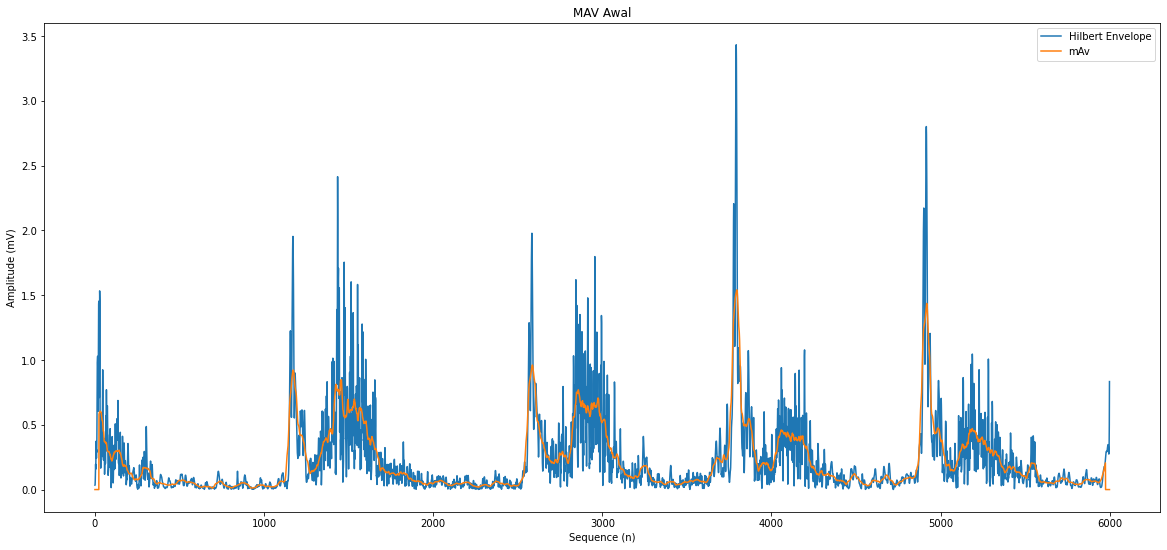

In [260]:
sum = 0
window = 50
mAver = []
k = int((window - 1) / 2)
for i in np.arange(k, len(et) - k):
    for ii in np.arange(i - k, i + k):
        sum = sum + et[ii]
    mAver.append(sum / window)
    sum = 0
zeros = [0] * k
mAver = zeros + mAver + zeros

plt.figure(figsize=((20, 9)))
plt.plot(et)
plt.plot(mAver)
plt.legend(["Hilbert Envelope", "mAv"])
plt.xlabel("Sequence (n)")
plt.ylabel("Amplitude (mV)")
plt.title("MAV Awal")
plt.show()

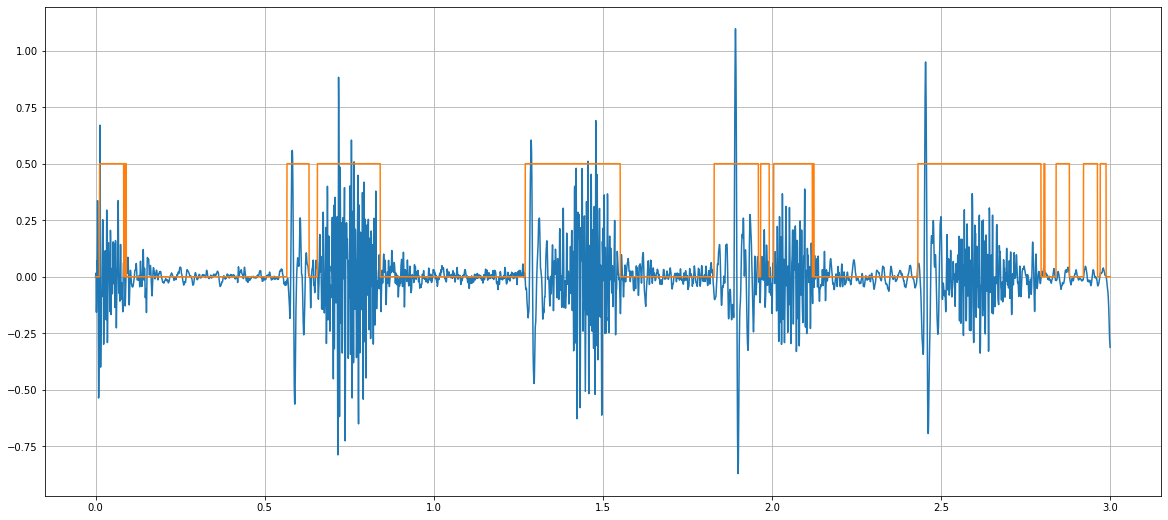

In [261]:
for t in range(len(et)):
    if mAver[t] < 0.12 * max(mAver):
        mAver[t] = 0
    else:
        mAver[t] = 0.5
a = np.arange(len(et))
plt.figure(figsize=((20, 9)))
plt.plot(a / fs, filtered_highpassMAV)
plt.plot(a / 2000, mAver)
plt.grid()

In [262]:
murmur = False
# print(len(mAver))
duration = 0
for i in range(len(mAver)):
    if mAver[i] == 0.5:
        duration += 1
    else:
        if duration > 0:
            duration = 0

    if duration == 700:
        murmur = True
        print(f"ada murmur di {i}")
        break

ada murmur di 5562
